<a href="https://colab.research.google.com/github/nancy-shih/Olympic/blob/main/Olympics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
!pip install beautifulsoup4 pandas
import requests
import pandas as pd
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import plotly.express as px

# 100 years Olympics

data cleaning

In [149]:
df_past = pd.read_csv('/content/veriseti_20220203_olimpiyatlar.csv')
df_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Gender  271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [150]:
#Add new column as won
df_past['Medal_Won'] = df_past['Medal'].apply(lambda x: 0 if pd.isna(x) else 1)
#data clean
df_past['Age'].fillna(df_past['Age'].mean(), inplace=True)
df_past['Height'].fillna(df_past['Height'].mean(), inplace=True)
df_past['Weight'].fillna(df_past['Weight'].mean(), inplace=True)
#get only summer games
df_past = df_past[df_past['Season'] == 'Summer']
df_past.drop(columns=['Games','Season','City','Team'], inplace=True)
# Replace 'URS' with 'ROC' in the 'NOC' column -- Russian got new name
df_past['NOC'] = df_past['NOC'].replace('URS', 'ROC')
df_past.head(5)

<ipython-input-150-8f3755ee3ca8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past.drop(columns=['Games','Season','City','Team'], inplace=True)
<ipython-input-150-8f3755ee3ca8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['NOC'] = df_past['NOC'].replace('URS', 'ROC')


,ID,Name,Gender,Age,Height,Weight,NOC,Year,Sport,Event,Medal,Medal_Won
0,1,A Dijiang,M,24.0,180.00000,80.000000,CHN,1992,Basketball,Basketball Men's Basketball,NaN,0
1,2,A Lamusi,M,23.0,170.00000,60.000000,CHN,2012,Judo,Judo Men's Extra-Lightweight,NaN,0
2,3,Gunnar Nielsen Aaby,M,24.0,175.33897,70.702393,DEN,1920,Football,Football Men's Football,NaN,0
3,4,Edgar Lindenau Aabye,M,34.0,175.33897,70.702393,DEN,1900,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1
26,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.00000,70.702393,NED,1932,Athletics,Athletics Women's 100 metres,NaN,0


### Distributions

In [151]:
grouped = df_past.groupby(['NOC'], as_index=False)['Medal_Won'].sum().sort_values(by='Medal_Won', ascending=False)
Top_10 = grouped.head(10)['NOC']
Top_10

216    USA
168    ROC
74     GBR
79     GER
69     FRA
100    ITA
12     AUS
90     HUN
194    SWE
145    NED
Name: NOC, dtype: object

In [152]:
filtered_df = df_past[df_past['NOC'].isin(Top_10)]
grouped = filtered_df.groupby(['NOC', 'Year'], as_index=False)['Medal_Won'].sum()
grouped.head(10)

,NOC,Year,Medal_Won
0,AUS,1896,3
1,AUS,1900,6
2,AUS,1904,4
3,AUS,1906,3
4,AUS,1920,7
5,AUS,1924,10
6,AUS,1928,4
7,AUS,1932,5
8,AUS,1936,1
9,AUS,1948,16


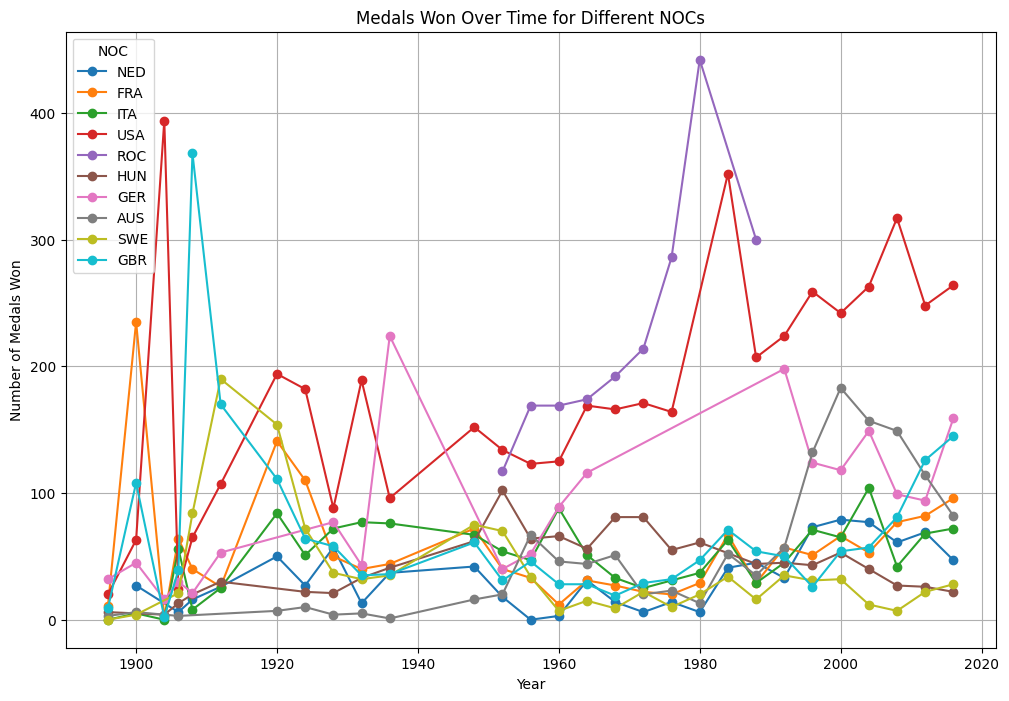

In [153]:

def plot_series(grouped, noc_name):
    data = grouped[grouped['NOC'] == noc_name]

    plt.plot(data['Year'], data['Medal_Won'], marker='o', linestyle='-', label=noc_name)

plt.figure(figsize=(12, 8))

unique_nocs = filtered_df['NOC'].unique()

for noc in unique_nocs:
    plot_series(grouped, noc)

plt.xlabel('Year')
plt.ylabel('Number of Medals Won')
plt.title('Medals Won Over Time for Different NOCs')
plt.legend(title='NOC')
plt.grid(True)
plt.show()


In [190]:
#gender and medal
grouped_sum = df_past.groupby(['NOC', 'Gender', 'Sport'], as_index=False)['Medal_Won'].sum()
grouped_count = df_past.groupby(['NOC', 'Gender', 'Sport'], as_index=False).size().rename(columns={'size': 'Athletics_Count'})

grouped = pd.merge(grouped_sum, grouped_count, on=['NOC', 'Gender', 'Sport'])
grouped['Medal_Ratio'] = grouped['Medal_Won'] / grouped['Athletics_Count']
grouped = grouped.sort_values(by='Medal_Ratio', ascending=False)
grouped.head(10)

,NOC,Gender,Sport,Medal_Won,Athletics_Count,Medal_Ratio
3973,ROC,M,Volleyball,71,71,1.0
1973,GER,M,Alpinism,2,2,1.0
3941,ROC,F,Handball,42,42,1.0
3942,ROC,F,Hockey,16,16,1.0
3943,ROC,F,Rhythmic Gymnastics,2,2,1.0
3945,ROC,F,Sailing,2,2,1.0
3951,ROC,F,Volleyball,70,70,1.0
3954,ROC,M,Basketball,110,110,1.0
3373,NED,F,Boxing,1,1,1.0
706,BUL,F,Volleyball,10,10,1.0


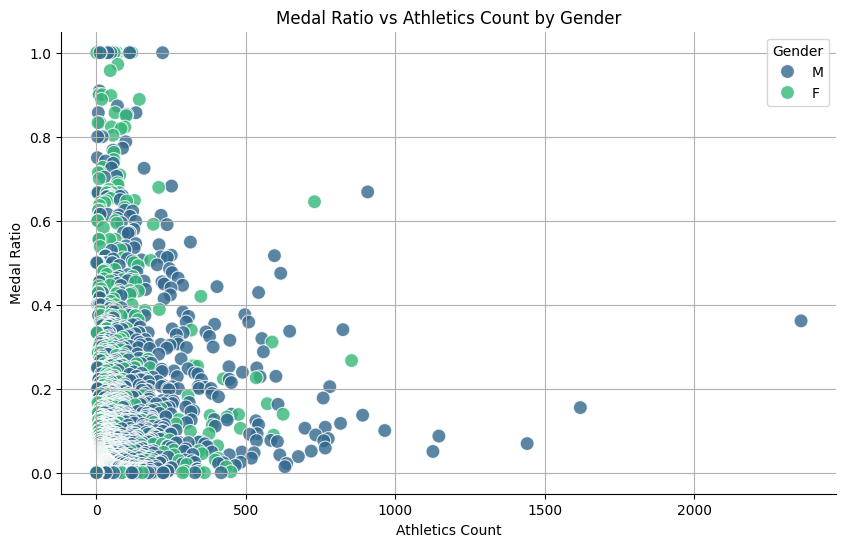

In [191]:
# Medal Ratio v.s Gender
# Create a scatter plot with different colors for each gender
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped, x='Athletics_Count', y='Medal_Ratio', hue='Gender', palette='viridis', s=100, alpha=0.8)

# Adjust the plots
plt.xlabel('Athletics Count')
plt.ylabel('Medal Ratio')
plt.title('Medal Ratio vs Athletics Count by Gender')
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [192]:
# Filter the dataframe to get rows where Male Athletics_Count is greater than 2000
male_athletics_high_count = grouped[(grouped['Gender'] == 'M') & (grouped['Athletics_Count'] > 2000)]

# Get the sports for these rows
sports_with_high_male_athletics_count = male_athletics_high_count[['Sport', 'Athletics_Count']]
sports_with_high_male_athletics_count

,Sport,Athletics_Count
5000,Athletics,2357


##Module1: build up Logistic Regression for perdition (All NOC)

In [154]:
features = ['Gender', 'Age', 'Height', 'Weight', 'NOC', 'Sport']
target = 'Medal_Won'

X = df_past[features]
y = df_past[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
# Preprocessing pipeline
categorical_features = ['Gender', 'NOC', 'Sport']
numerical_features = ['Age', 'Height', 'Weight']

# One-hot encode categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scale numerical features
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Append classifier to preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'NOC', 'Sport']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height',
                                                   'Weight'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [156]:
# Predict using the model on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report and confusion matrix for more detailed evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     37703
           1       0.58      0.09      0.15      6808

    accuracy                           0.85     44511
   macro avg       0.72      0.54      0.53     44511
weighted avg       0.81      0.85      0.80     44511

[[37283   420]
 [ 6224   584]]


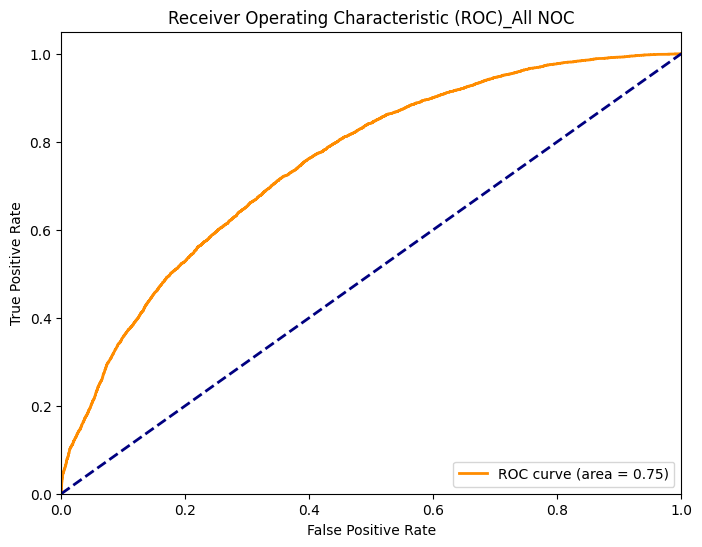

In [157]:
# Predict probabilities using the model on the testing data
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt_1 = plt.figure(figsize=(8, 6))
plt_1 = plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt_1 = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt_1 = plt.xlim([0.0, 1.0])
plt_1 = plt.ylim([0.0, 1.05])
plt_1 = plt.xlabel('False Positive Rate')
plt_1 = plt.ylabel('True Positive Rate')
plt_1 = plt.title('Receiver Operating Characteristic (ROC)_All NOC')
plt_1 = plt.legend(loc='lower right')
plt_1


##Module2: build up Logistic Regression for perdition (USA)

In [158]:
df_USA = df_past[df_past['NOC'] == 'USA']
df_USA.head(5)

,ID,Name,Gender,Age,Height,Weight,NOC,Year,Sport,Event,Medal,Medal_Won
186,84,Stephen Anthony Abas,M,26.0,165.00000,55.000000,USA,2004,Wrestling,"Wrestling Men's Featherweight, Freestyle",Silver,1
273,142,"David ""Dave"" Abbott",M,26.0,183.00000,75.000000,USA,1928,Athletics,"Athletics Men's 5,000 metres",NaN,0
282,149,Mara Katherine Abbott,F,30.0,163.00000,52.000000,USA,2016,Cycling,"Cycling Women's Road Race, Individual",NaN,0
283,150,Margaret Ives Abbott (-Dunne),F,23.0,175.33897,70.702393,USA,1900,Golf,Golf Women's Individual,Gold,1
284,151,Mary Perkins Ives Abbott (Perkins-),F,42.0,175.33897,70.702393,USA,1900,Golf,Golf Women's Individual,NaN,0


In [277]:
features = ['Gender', 'Age', 'Height', 'Weight', 'Sport']
target = 'Medal_Won'

X = df_USA[features]
y = df_USA[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [278]:
# Preprocessing pipeline
categorical_features = ['Gender', 'Sport']
numerical_features = ['Age', 'Height', 'Weight']

# One-hot encode categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scale numerical features
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Append classifier to preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Sport']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height',
                                                   'Weight'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [279]:
# Predict using the model on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report and confusion matrix for more detailed evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      2026
           1       0.71      0.34      0.46       987

    accuracy                           0.74      3013
   macro avg       0.73      0.64      0.65      3013
weighted avg       0.73      0.74      0.71      3013

[[1890  136]
 [ 647  340]]


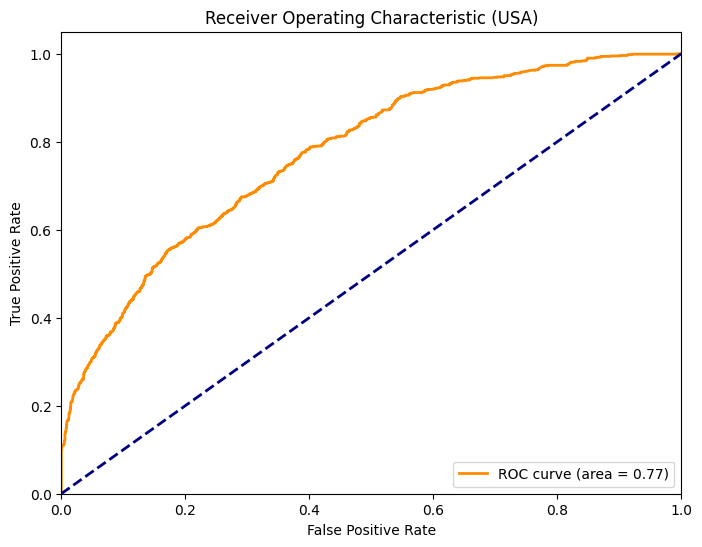

In [280]:
# Predict probabilities using the model on the testing data
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt_2 = plt.figure(figsize=(8, 6))
plt_2 = plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt_2 = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt_2 = plt.xlim([0.0, 1.0])
plt_2 = plt.ylim([0.0, 1.05])
plt_2 = plt.xlabel('False Positive Rate')
plt_2 = plt.ylabel('True Positive Rate')
plt_2 = plt.title('Receiver Operating Characteristic (USA)')
plt_2 = plt.legend(loc='lower right')
plt_2 = plt.show()

# 2021 Tokyo Olympics Team USA

[USA Today Website](https://www.usatoday.com/storytelling/2021-olympics-tokyo-team-usa-roster/USA/all/)\
Get to know every athlete at the 2021 Tokyo Olympics: Team USA athletes
Meet the more than 600 American athletes competing at the 2021 Tokyo Summer Olympics.



In [163]:
# Step 1: Fetch the HTML content from the URL and save it to a file
url = "https://www.usatoday.com/storytelling/2021-olympics-tokyo-team-usa-roster/USA/all/"
response = requests.get(url)

if response.status_code == 200:
    with open("team_usa_roster.html", "w", encoding="utf-8") as file:
        file.write(response.text)
else:
    print(f"Failed to fetch the page. Status code: {response.status_code}")

# Step 2: Read the saved HTML file, parse it, extract data, and save it to a CSV file
# Load the HTML file
with open('team_usa_roster.html', 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')


In [164]:
import requests
import pandas as pd
# Initialize lists to store data
athletes = []
hometowns = []
birthplaces = []
ages = []

# Find all athlete entries
athlete_entries = soup.find_all('li', class_='athlete')

# Iterate through each athlete entry
for athlete in athlete_entries:
    # Extract athlete name
    name_element = athlete.find('h3', class_='athlete__name')
    name = name_element.text.strip() if name_element else ''
    athletes.append(name)

    # Extract athlete details
    details = athlete.find_all('li', class_='athlete__detail')

    # Initialize default values for details
    hometown = ''
    birthplace = ''
    age = ''

    # Iterate through details to find specific information
    for detail in details:
        if 'Hometown:' in detail.text:
            hometown = detail.find('span', class_='athlete__value').text.strip()
        elif 'Birthplace:' in detail.text:
            birthplace = detail.find('span', class_='athlete__value').text.strip()
        elif 'Age:' in detail.text:
            age = detail.find('span', class_='athlete__value').text.strip()

    # Append details to lists
    hometowns.append(hometown)
    birthplaces.append(birthplace)
    ages.append(age)

# Create a DataFrame
data = {
    'Athlete': athletes,
    'Hometown': hometowns,
    'Birthplace': birthplaces,
    'Age': ages
}

df_2021 = pd.DataFrame(data)
df_2021.head(10)

,Athlete,Hometown,Birthplace,Age
0,Mackenzie Brown,"Flint, Texas","Flint, Texas",26
1,Brady Ellison,"Globe, Ariz.",,32
2,Casey Kaufhold,"Lancaster, Pa.",,17
3,Jennifer Mucino-Fernandez,"Mexico City, Mexico",Boston,18
4,Jack Williams,"Irvine, Calif.","Irvine, Calif.",21
5,Jacob Wukie,"Oak Harbor, Ohio","Massillon, Ohio",35
6,Phillip Chew,"Orange, Calif.","Anaheim, Calif.",27
7,Ryan Chew,,,24
8,Timothy Lam,,,23
9,Beiwen Zhang,Las Vegas,,31


### Distributions

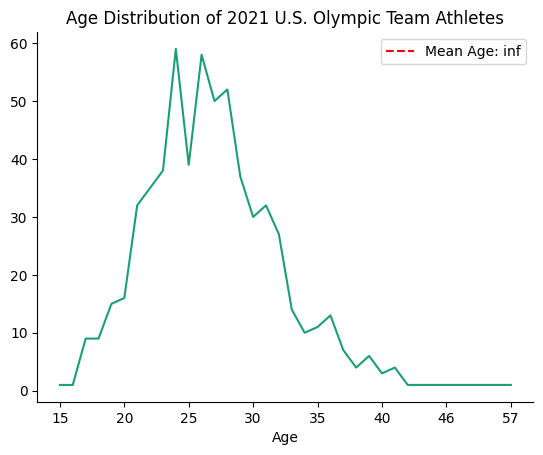

In [165]:
df_2021.groupby('Age').size().plot(color=sns.palettes.mpl_palette('Dark2'))

mean_age = df_2021['Age'].mean()
plt.title('Age Distribution of 2021 U.S. Olympic Team Athletes')
plt.axvline(mean_age, color='red', linestyle='--', linewidth=1.5, label=f'Mean Age: {mean_age:.2f}')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

###combine the winning list

In [194]:
# Send a GET request to fetch the HTML content
response = requests.get("https://en.wikipedia.org/wiki/United_States_at_the_2020_Summer_Olympics")
html_content = response.text

# Parse the HTML using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

"Wrestling - Women's freestyle 50 kg: August 7"

In [199]:
# Find the table containing the medalists
table = soup.find('table', class_='wikitable sortable')

# Initialize lists to store the data
medals = []
names = []
sports = []
events = []

# Iterate through rows in the table skipping the header row
for row in table.find_all('tr')[1:]:
    # Extract data from each column (td tags) in the row
    columns = row.find_all('td')

    # Extracting data assuming columns are consistent with the structure
    medal = columns[0].text.strip()
    name = columns[1].text.strip()
    sport = columns[2].text.strip()
    event = columns[3].text.strip()

    # Append data to lists
    medals.append(medal)
    names.append(name)
    sports.append(sport)
    events.append(event)

# Create a dataframe from the lists
data = {
    'Medal': medals,
    'Name': names,
    'Sport': sports,
    'Event': events
}

df_2021win = pd.DataFrame(data)
df_2021win.head(10)

,Medal,Name,Sport,Event
0,Gold,Lee Kiefer,Fencing,Women's foil
1,Gold,Will Shaner,Shooting,Men's 10 m air rifle
2,Gold,Chase Kalisz,Swimming,Men's 400 m individual medley
3,Gold,Anastasija Zolotic,Taekwondo,Women's −57 kg
4,Gold,Zach AppleBowe BeckerBrooks Curry[a]Caeleb Dre...,Swimming,Men's 4 × 100 m freestyle relay
5,Gold,Vincent Hancock,Shooting,Men's skeet
6,Gold,Amber English,Shooting,Women's skeet
7,Gold,Carissa Moore,Surfing,Women's shortboard
8,Gold,Lydia Jacoby,Swimming,Women's 100 m breaststroke
9,Gold,United States women's national 3x3 teamStefani...,Basketball,Women's 3x3 tournament


In [205]:
#combing two dataset
# Perform left join
merged_df = pd.merge(df_2021, df_2021win, left_on='Athlete', right_on='Name', how='left')

# Drop the redundant 'Name' column after merge
merged_df.drop(columns=['Name'], inplace=True)

merged_df[merged_df['Medal'] == 'Gold']

,Athlete,Hometown,Birthplace,Age,Medal,Sport,Event
88,Nevin Harrison,Seattle,Seattle,19,Gold,Canoeing,Women's C-1 200 m
103,Jennifer Valente,San Diego,San Diego,26,Gold,Cycling,Women's omnium
135,Lee Kiefer,"Lexington, Ky.",Cleveland,27,Gold,Fencing,Women's foil
148,Nelly Korda,"Bradenton, Fla.",,22,Gold,Golf,Women's
150,Xander Schauffele,San Diego,San Diego,27,Gold,Golf,Men's
154,Jade Carey,Phoenix,Phoenix,21,Gold,Gymnastics,Women's floor
156,Sunisa Lee,"St. Paul, Minn.","St. Paul, Minn.",18,Gold,Gymnastics,Women's artistic individual all-around
268,Amber English,"Colorado Springs, Colo.","Colorado Springs, Colo.",31,Gold,Shooting,Women's skeet
270,Vincent Hancock,"Eatonton, Ga.","Port Charlotte, Fla.",32,Gold,Shooting,Men's skeet
279,Will Shaner,"Colorado Springs, Colo.","Colorado Springs, Colo.",20,Gold,Shooting,Men's 10 m air rifle


No charts were generated by quickchart


In [225]:
gold_winners = merged_df[merged_df['Medal'] == 'Gold']

hometown_to_state = {
    'Seattle': 'WA', 'San Diego': 'CA', 'Lexington, Ky.': 'KY', 'Bradenton, Fla.': 'FL', 'Phoenix': 'AZ',
    'St. Paul, Minn.': 'MN', 'Colorado Springs, Colo.': 'CO', 'Eatonton, Ga.': 'GA', 'Honolulu': 'HI', 'Green Cove Springs, Fla.': 'FL',
    'Anchorage, Alaska': 'AK', 'Bel Air, Md.': 'MD', 'Bethesda, Md.': 'MD', 'Largo, Fla.': 'FL', 'Newark, Del.': 'DE',
    'Boring, Ore.': 'OR', 'Dunellen, N.J.': 'NJ', 'Trenton, N.J.': 'NJ', 'Olmsted Falls, Ohio': 'OH', 'Apple Valley, Minn.': 'MN',
    'State College, Pa.': 'PA', 'Portland, Ore.': 'OR', 'New Brunswick, N.J.': 'NJ', 'St. Paris, Ohio': 'OH'
}

# Add a column for Hometown's State
gold_winners['Hometown_State'] = gold_winners['Hometown'].map(hometown_to_state)

# Display the updated DataFrame
gold_winners.head(10)


<ipython-input-225-efc037ac0088>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Athlete,Hometown,Birthplace,Age,Medal,Sport,Event,Hometown_State
88,Nevin Harrison,Seattle,Seattle,19,Gold,Canoeing,Women's C-1 200 m,WA
103,Jennifer Valente,San Diego,San Diego,26,Gold,Cycling,Women's omnium,CA
135,Lee Kiefer,"Lexington, Ky.",Cleveland,27,Gold,Fencing,Women's foil,KY
148,Nelly Korda,"Bradenton, Fla.",,22,Gold,Golf,Women's,FL
150,Xander Schauffele,San Diego,San Diego,27,Gold,Golf,Men's,CA
154,Jade Carey,Phoenix,Phoenix,21,Gold,Gymnastics,Women's floor,AZ
156,Sunisa Lee,"St. Paul, Minn.","St. Paul, Minn.",18,Gold,Gymnastics,Women's artistic individual all-around,MN
268,Amber English,"Colorado Springs, Colo.","Colorado Springs, Colo.",31,Gold,Shooting,Women's skeet,CO
270,Vincent Hancock,"Eatonton, Ga.","Port Charlotte, Fla.",32,Gold,Shooting,Men's skeet,GA
279,Will Shaner,"Colorado Springs, Colo.","Colorado Springs, Colo.",20,Gold,Shooting,Men's 10 m air rifle,CO


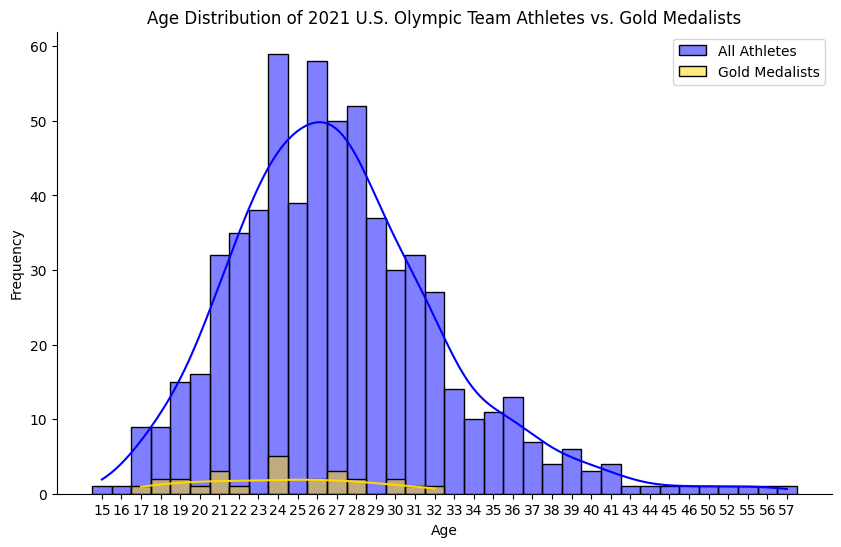

In [285]:
# Sort ages for all athletes in df_2021
sorted_age_all = df_2021['Age'].sort_values()

# Sort ages for gold medalists in merged_df
sorted_age_gold = merged_df[merged_df['Medal'] == 'Gold']['Age'].sort_values()

# Plotting the age distribution of all athletes in df_2021
plt.figure(figsize=(10, 6))
sns.histplot(sorted_age_all, bins=20, kde=True, color='blue', alpha=0.5, label='All Athletes')

# Plotting the age distribution of gold medalists in merged_df
sns.histplot(sorted_age_gold, bins=20, kde=True, color='gold', alpha=0.5, label='Gold Medalists')

# Adding plot labels and legend
plt.title('Age Distribution of 2021 U.S. Olympic Team Athletes vs. Gold Medalists')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Removing top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Display the plot
plt.show()


Inspired by this essey, I am curious were the most gold state remain the same?\

https://www.businessinsider.com/us-olympic-gold-medals-by-state-map-2014-1

In [232]:
# Count number of Gold medal winners per state
gold_counts = gold_winners['Hometown_State'].value_counts().reset_index()
gold_counts.columns = ['State', 'Gold_Count']

# Plotly Express choropleth map of USA
fig = px.choropleth(locations=gold_counts['State'],  # State codes
                    locationmode='USA-states',  # Specify USA states
                    color=gold_counts['Gold_Count'],  # Color by Gold_Count
                    scope='usa',  # Scope of the map
                    color_continuous_scale='YlOrRd',  # Color scale
                    labels={'color': 'Number of Gold Medal Winners Hometown'},  # Label for legend
                    title='Gold Medal Winners Hometowns in USA')  # Title of the plot

# Show the plot
fig.show()

Surprisily Cal is not the most gold state in 2021 Olympics, but Fl

### Module3: build up Logistic Regression for perdition (USA_2021)

In [257]:
merged_df['Medal_Won'] = merged_df['Medal'].apply(lambda x: 0 if pd.isna(x) else 1)
features = ['Age', 'Hometown', 'Sport']
target = 'Medal_Won'

X = merged_df[features]
y = merged_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [259]:
# Preprocessing pipeline
categorical_features = ['Hometown', 'Sport']
numerical_features = ['Age']

# One-hot encode categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Scale numerical features
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Append classifier to preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Hometown', 'Sport']),
                                                 ('num', StandardScaler(),
                                                  ['Age'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [260]:
# Predict using the model on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report and confusion matrix for more detailed evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00        11

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

[[115   0]
 [  0  11]]


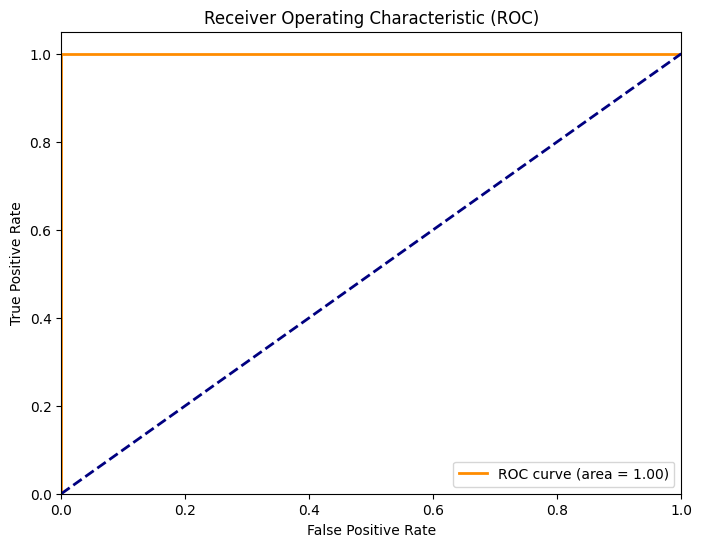

In [261]:
# Predict probabilities using the model on the testing data
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt_2 = plt.figure(figsize=(8, 6))
plt_2 = plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt_2 = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt_2 = plt.xlim([0.0, 1.0])
plt_2 = plt.ylim([0.0, 1.05])
plt_2 = plt.xlabel('False Positive Rate')
plt_2 = plt.ylabel('True Positive Rate')
plt_2 = plt.title('Receiver Operating Characteristic (ROC)')
plt_2 = plt.legend(loc='lower right')
plt_2 = plt.show()

# 2024 Paris Olympics Team USA

In [166]:
# Path to the Excel file
file_path = '/2024_U.S._Olympic_Team_July_10.xlsx'
df_2024 = pd.read_excel(file_path)

# Drop the first row and reset the index
df_2024.columns = df_2024.iloc[0]
df_2024 = df_2024.drop(0).reset_index(drop=True)
df_2024 = pd.DataFrame(df_2024)
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   First Name      592 non-null    object
 1   Last Name       592 non-null    object
 2   Sport           592 non-null    object
 3   Hometown City   592 non-null    object
 4   Hometown State  592 non-null    object
 5   Gender          592 non-null    object
 6   Event           592 non-null    object
dtypes: object(7)
memory usage: 32.5+ KB


In [167]:
df_2024.head(5)

,First Name,Last Name,Sport,Hometown City,Hometown State,Gender,Event
0,BRADY,ELLISON,Archery,Billings,Montana,Male,Men's Individual
1,CATALINA,GNORIEGA,Archery,San Diego,California,Female,"Women's Individual, Women's Team"
2,CASEY,KAUFHOLD,Archery,Lancaster,Pennsylvania,Female,"Women's Individual, Women's Team"
3,JENNIFER,MUCINO-FERNANDEZ,Archery,Chula Vista,California,Female,"Women's Individual, Women's Team"
4,ANITA,ALVAREZ,Artistic Swimming,Buffalo,New York,Female,Team


### Distributions

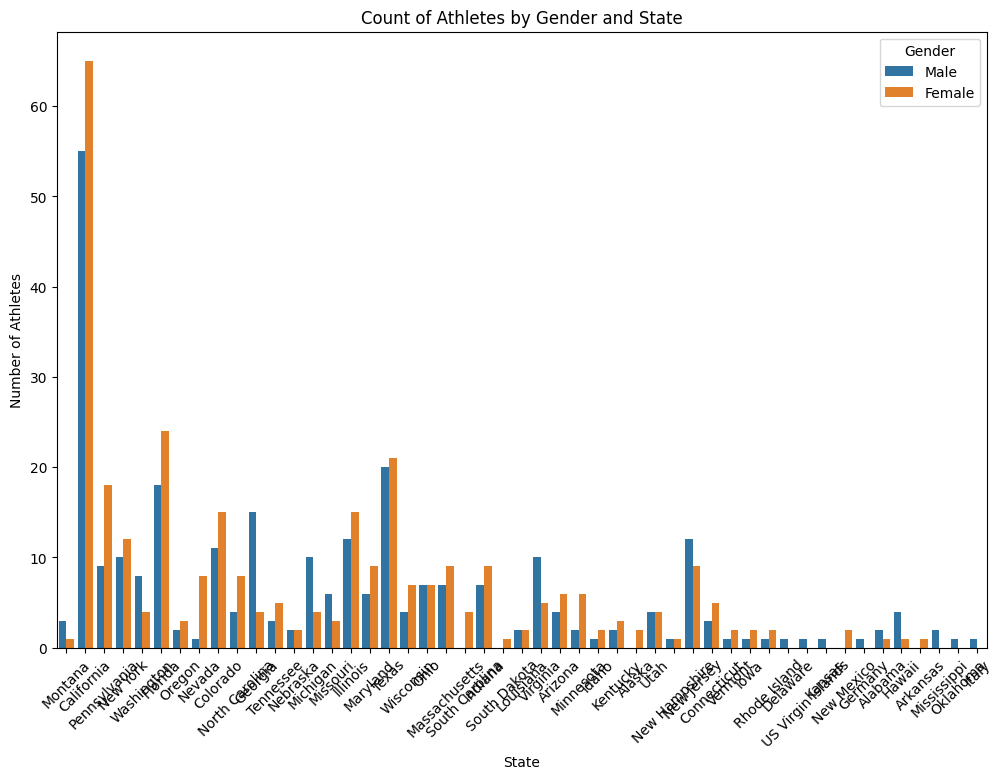

In [252]:
# Count of athletes by gender and state
plt.figure(figsize=(12, 8))
sns.countplot(x='Hometown State', hue='Gender', data=df_2024)
plt.title('Count of Athletes by Gender and State')
plt.xlabel('State')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.show()

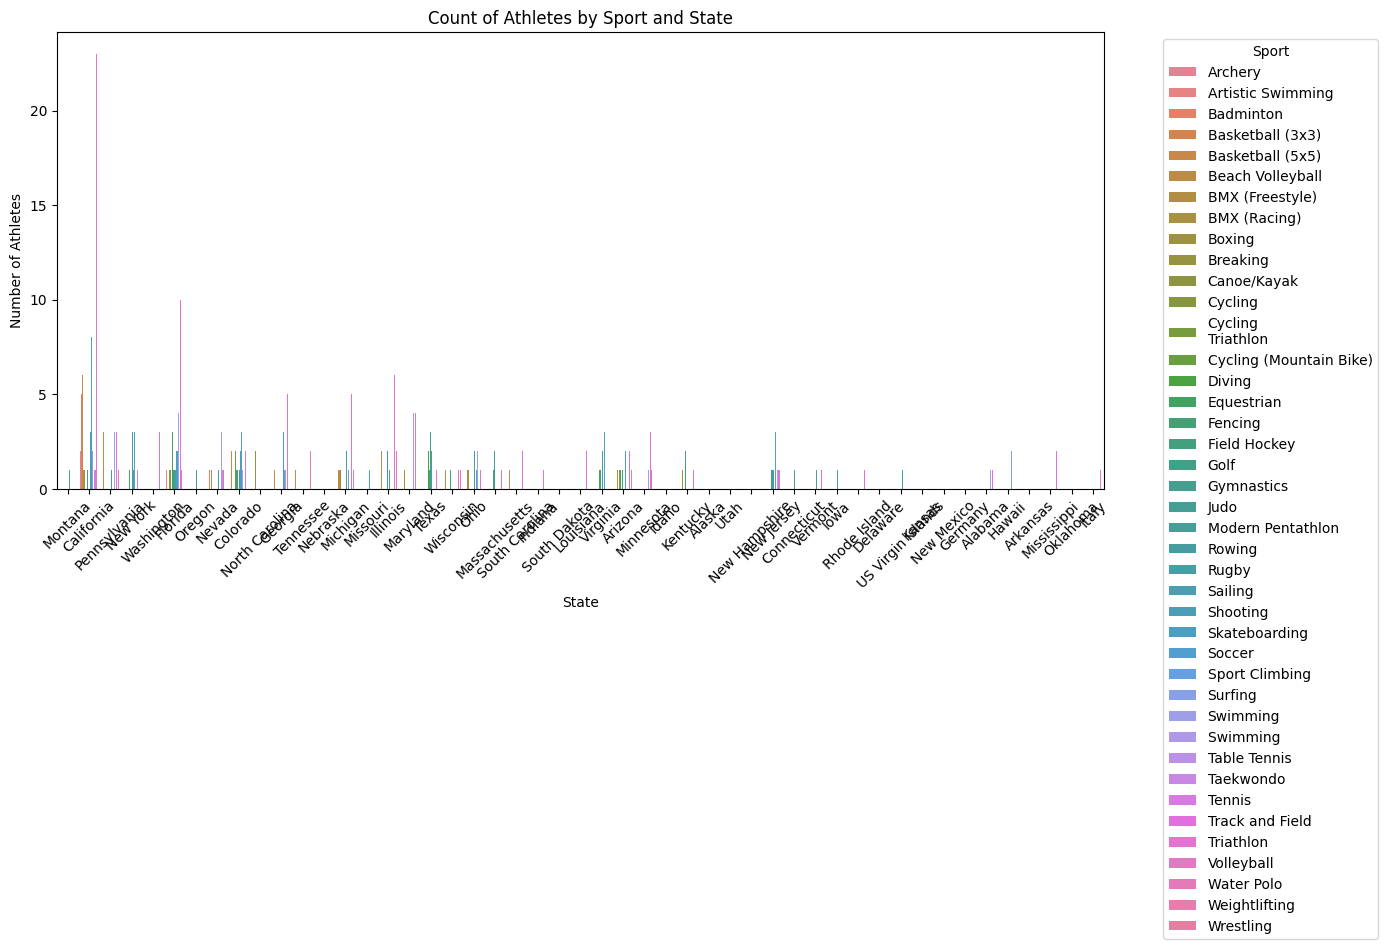

In [263]:
# Count of athletes by sport and state
plt.figure(figsize=(14, 8))
sns.countplot(x='Hometown State', hue='Sport', data=df_2024)
plt.title('Count of Athletes by Sport and State')
plt.xlabel('State')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45)
plt.legend(title='Sport', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [276]:
sport_counts_mt = df_2024[df_2024['Hometown State'] == 'California'].groupby('Sport').size().reset_index(name='Count')

# Filter sports with more than 20 people
sport_counts_mt_gt_20 = sport_counts_mt[sport_counts_mt['Count'] > 20]

# Display the filtered rows
print(sport_counts_mt_gt_20)

         Sport  Count
30  Water Polo     23


In [248]:
state_mapping = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Map the Hometown State column using the mapping dictionary
df_2024['Hometown_State'] = df_2024['Hometown State'].map(state_mapping)

# Count number of people per state
people_counts = df_2024['Hometown_State'].value_counts().reset_index()
people_counts.columns = ['Hometown_State', 'People_Count']

# Plotly Express choropleth map of USA
fig = px.choropleth(locations=people_counts['Hometown_State'],  # State codes
                    locationmode='USA-states',  # Specify USA states
                    color=people_counts['People_Count'],  # Color by People_Count
                    scope='usa',  # Scope of the map
                    color_continuous_scale='YlOrRd',  # Color scale
                    labels={'color': 'Number of People'},  # Label for legend
                    title='Number of People by Hometown State')  # Title of the plot

# Show the plot
fig.show()

## Prediction: Module1

## Prediction: Module2

## Prediction: Module3